In [7]:
import torch
import os
import numpy as np
from torchsummary import summary
from torch import nn, Tensor
import torch.optim as optim
from torch import hub
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import csv
import sys
import time
from functools import partial
from EfficientNet import MBConvConfig, EfficientNet_final
from ResNet_ORIGINAL import ResNet_ORIGINAL_model_final
import torch.functional as F


if torch.cuda.is_available():
    device = torch.device("cuda") 
    print("Using GPUs ", device)
else:
    device = torch.device("cpu")

Using GPUs  cuda


In [8]:

batch_size_train = 96
batch_size_validation = 4
num_classes = 1000
crop_size = 224
resize_size = 256
# crop_size = 600
# resize_size = 600

train_path = 'imagenet_dataset/ILSVRC/Data/CLS-LOC/train'
valid_path = 'imagenet_dataset/ILSVRC/Data/CLS-LOC/val'

transform_train = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize(resize_size),
    transforms.CenterCrop(crop_size),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


transform_valid = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize(resize_size),
    transforms.CenterCrop(crop_size),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


imagenet_train = torchvision.datasets.ImageFolder(train_path, transform=transform_train)
imagenet_valid = torchvision.datasets.ImageFolder(valid_path, transform=transform_valid)

train_loader = torch.utils.data.DataLoader(
    imagenet_train,
    batch_size=batch_size_train,
    num_workers=8,
    pin_memory=True,
    shuffle=True
)

valid_loader = torch.utils.data.DataLoader(
    imagenet_valid,
    batch_size=batch_size_validation,
    num_workers=8,
    pin_memory=True)


train_size = len(imagenet_train)
valid_size = len(imagenet_valid)

data_loaders = {"train": train_loader, "validation": valid_loader, "test": valid_loader}
dataset_sizes = {"train": train_size, "validation": valid_size, "test": valid_size}




In [9]:
# scales for EfficientNetB0
width_mult = 1.0
depth_mult = 1.0
do = 0.2
# norm_layer = partial(nn.BatchNorm2d, eps=0.001, momentum=0.01)
norm_layer = nn.BatchNorm2d

inverted_residual_setting = [
    MBConvConfig(1, 3, 1, 32, 16, 1, width_mult, depth_mult),
    MBConvConfig(6, 3, 2, 16, 24, 2, width_mult, depth_mult),
    MBConvConfig(6, 5, 2, 24, 40, 2, width_mult, depth_mult),
    MBConvConfig(6, 3, 2, 40, 80, 3, width_mult, depth_mult),
    MBConvConfig(6, 5, 1, 80, 112, 3, width_mult, depth_mult),
    MBConvConfig(6, 5, 2, 112, 192, 4, width_mult, depth_mult),
    MBConvConfig(6, 3, 1, 192, 320, 1, width_mult, depth_mult),
]


selected_exits = np.array([8])
model = EfficientNet_final(inverted_residual_setting, dropout=do, stochastic_depth_prob=0.2, norm_layer=norm_layer, num_classes=num_classes, selected_exits=selected_exits).to(device)


### freeze the backbone model
for param in model.named_parameters():
    if 'exit_br' in param[0] and 'exit_br8' not in param[0]:
        param[1].requires_grad = True 

### loading pytorch weights on the new efficientnet model, 
# by changing keys and ignoring exit branches
the_dict_mine = model.state_dict()
the_dict_theirs = torch.load('weights/efficientnet_b0_rwightman-3dd342df.pth')
new_dict = {}
for key_mine, key_thiers in zip(the_dict_mine, the_dict_theirs):
    # print(key_mine, key_thiers)
    if 'exit' not in key_mine:
        new_dict[key_mine] = the_dict_theirs[key_thiers]

# manually adding the last exit btanch (br8)
new_dict['layers_dict.exit_br8.3.weight'] = the_dict_theirs['classifier.1.weight']
new_dict['layers_dict.exit_br8.3.bias'] = the_dict_theirs['classifier.1.bias']

model.load_state_dict(new_dict, strict=False)

torch.save(model.state_dict(),f"saved_models/EfficientNetB0_ImageNet_state_dict_final[8].pt")
torch.save(model,f"saved_models/EfficientNetB0_ImageNet_entire_model_final[8].pt")


In [10]:
epochs = 10
start_lr = 0.01

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=start_lr, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7], gamma=0.1)

In [ ]:
iind = 0
for epoch in range(epochs):
    start_time = time.time()
    print("Epoch {}/{}".format(epoch, epochs - 1))
    print("-" * 30, flush=True)

    epoch_loss = {"train": [0.0 for i in range(len(selected_exits))], 
                "validation": [0.0 for i in range(len(selected_exits))]}
    epoch_acc = {"train": [0.0 for i in range(len(selected_exits))], 
                "validation": [0.0 for i in range(len(selected_exits))]}
    
    running_loss = {"train": [0.0 for i in range(len(selected_exits))], 
                    "validation": [0.0 for i in range(len(selected_exits))]}
    running_corrects = {"train": [0 for i in range(len(selected_exits))], 
                        "validation": [0 for i in range(len(selected_exits))]}

    for phase in ["train", "validation"]:
        if phase == "train":
            for key in model.layers_dict:
                for key2 in model.layers_dict[key]:
                    if isinstance(key2, nn.Dropout):
                        print(key2)
                        key2.train(True)
        else:
            for key in model.layers_dict:
                for key2 in model.layers_dict[key]:
                    if isinstance(key2, nn.Dropout):
                        key2.train(False)
        
        # for each batch in dataset
        for data in data_loaders[phase]:
            iind += 1
            inputs, labels = data 
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # clear all gradients
            optimizer.zero_grad() 

            # forward pass
            outputs = model(inputs) 

            # calculate loss for all branches
            loss_list = torch.tensor(0.0, requires_grad=True, device=device)
            for out in outputs:
                loss_list = torch.hstack((loss_list, loss_fn(out, labels)))
                
                
            # sum losses from all branches, no weight
            loss = torch.sum(loss_list)

            # packward pass
            if phase == "train":
                # compute gradients
                loss.backward()  
                # update weights/biases
                optimizer.step() 
            

            # update the running loss and corrects for this batch
            for i in range(len(selected_exits)):
                _, preds = torch.max(outputs[i], 1)
                running_loss[phase][i] += loss_list[i+1].data.item() * inputs.size(0)
                running_corrects[phase][i] += torch.sum(preds == labels.data).item()
                

        # update the epoch loss and acc    
        epoch_loss[phase] = np.array(running_loss[phase]) / dataset_sizes[phase]
        epoch_acc[phase] =  np.array(running_corrects[phase]) / dataset_sizes[phase]


    # update learning rate when necessary
    scheduler.step()

    print('--------------time:', np.round(time.time()-start_time, 5), "\n",
        'train_loss:', np.round(epoch_loss["train"], 4), "\n",
        'train_acc:', np.round(epoch_acc["train"], 4), "\n",
        'val_loss:', np.round(epoch_loss["validation"], 4), "\n",
        'val_acc:', np.round(epoch_acc["validation"], 4), "\n", flush=True)



# save the model
na = str(list(selected_exits)).replace(" ", "")
torch.save(model.state_dict(),f"saved_models/EfficientNetB7_ImageNet_state_dict_final{na}.pt")
torch.save(model,f"saved_models/EfficientNetB7_ImageNet_entire_model_final{na}.pt")

In [11]:

print("----- test " )
model.train(False)
with torch.no_grad():
    start_time = time.time()

    running_loss = [0.0 for i in range(len(selected_exits))]
    running_corrects = [0 for i in range(len(selected_exits))]

    for data in data_loaders['test']:
        inputs, labels = data 
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(inputs) 

        # calculate loss for all branches
        loss_list = torch.tensor(0.0, requires_grad=True, device=device)
        for out in outputs:
            loss_list = torch.hstack((loss_list, loss_fn(out, labels)))
            
        # update the running loss and corrects for this batch
        for i in range(len(selected_exits)):
            _, preds = torch.max(outputs[i], 1)
            running_loss[i] += loss_list[i+1].data.item() * inputs.size(0)
            running_corrects[i] += torch.sum(preds == labels.data).item()

            
    print('time:', np.round(time.time()-start_time, 5), "\n",
        'test_loss:', np.round(np.array(running_loss)/ dataset_sizes['test'], 4), "\n",
        'test_acc:', np.round(np.array(running_corrects)/ dataset_sizes['test'], 4))
    

----- test 
time: 99.19482 
 test_loss: [0.9689] 
 test_acc: [0.7739]


In [1]:
import numpy as np
epoch_train_acc_list = []
epoch_valid_acc_list = []

for line in open('screen_train_allexit_sgd_01_last.txt', 'r'):
    if 'train_acc' in line:
        line = line[line.find('[')+1: line.find(']')]
        epoch_train_acc_list.append(np.array([float(s) for s in line.split(' ') if len(s)>2]))

    if 'val_acc' in line:
        line = line[line.find('[')+1: line.find(']')]
        epoch_valid_acc_list.append(np.array([float(s) for s in line.split(' ') if len(s)>2]))


epoch_train_acc_list = np.transpose(np.array(epoch_train_acc_list))
epoch_valid_acc_list = np.transpose(np.array(epoch_valid_acc_list))

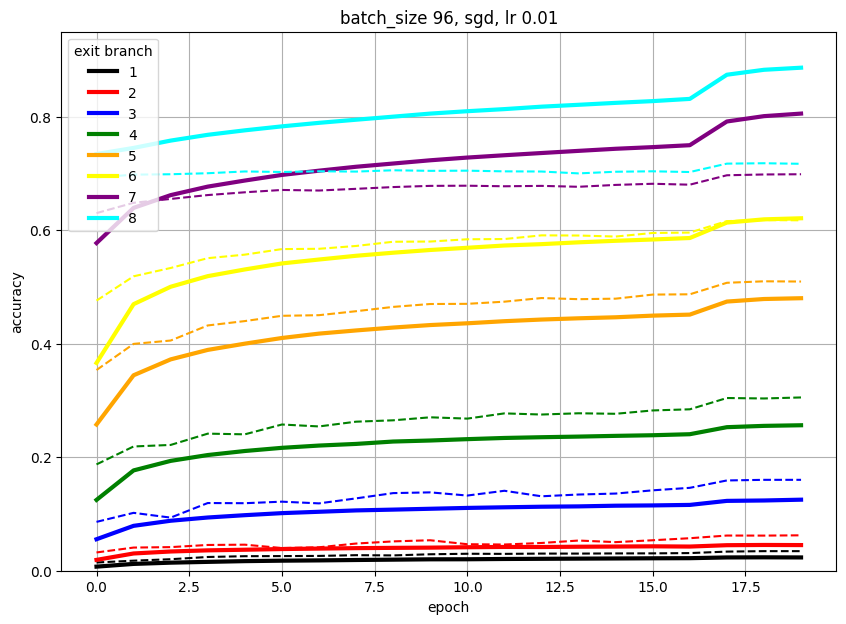

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
color=['black', 'red', 'blue', 'green', 'orange', 'yellow', 'purple', 'cyan', 'pink', 'gray', 'olive', 'brown']
for ind, (train_line, valid_line) in enumerate(zip(epoch_train_acc_list, epoch_valid_acc_list)):
    plt.plot(train_line, color=color[ind], linewidth=3, label=ind+1)
    plt.plot(valid_line, color=color[ind], linestyle='--')
plt.title(f"batch_size 96, sgd, lr 0.01")
plt.grid()
plt.ylabel('accuracy')
plt.legend(title='exit branch')
plt.xlabel('epoch')
plt.ylim(0, 0.95)
plt.show()

